## Урок 2. Кейс 1. Преобразование признаков

**Вопрос 1.** Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти" .


In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

%matplotlib inline
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score


In [3]:
data = pd.read_csv('my_PJME_MW.csv', sep=',', index_col = [0], parse_dates = [0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Text(0, 0.5, 'Мвт')

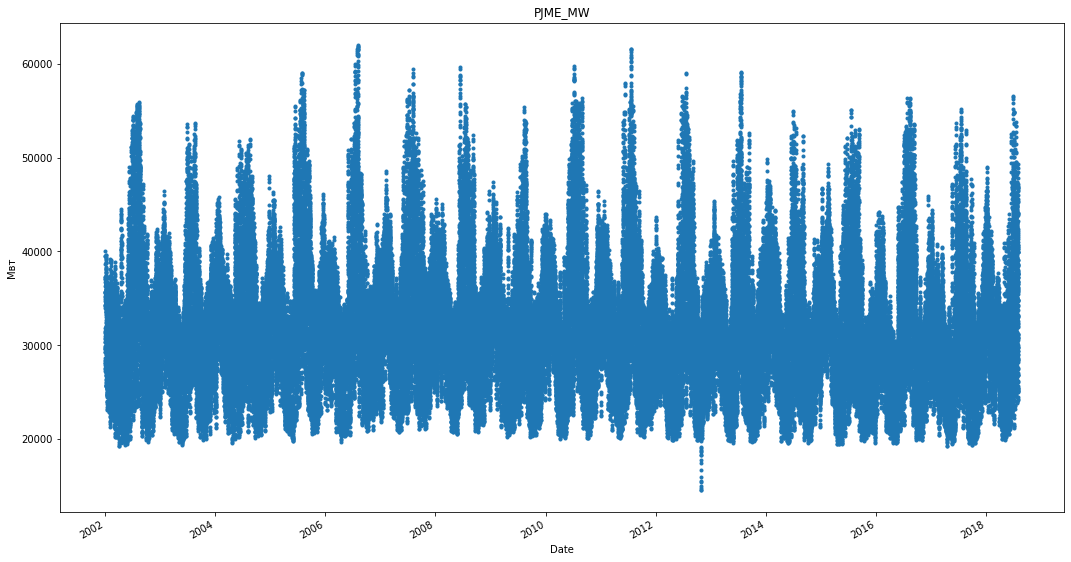

In [8]:
data['PJME_MW'].plot(style='.', figsize=(18,10), title='PJME_MW')
plt.ylabel('Мвт')

Text(0, 0.5, 'Мвт')

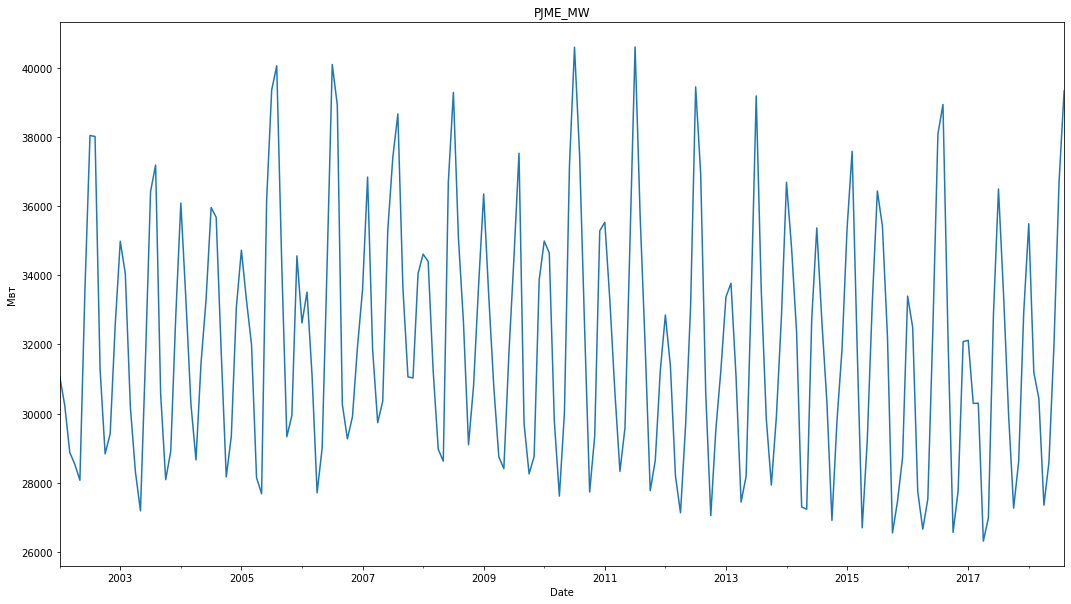

In [12]:
data_m = data.resample('M').mean()

data_m['PJME_MW'].plot(style='-', figsize=(18,10), title='PJME_MW')
plt.ylabel('Мвт')

Проверим несглаженный ряд на стационарность

In [20]:
sm.tsa.stattools.adfuller(data_m['PJME_MW'].values, regression='ctt')

(-2.5774555917298194,
 0.5247860093675522,
 15,
 184,
 {'1%': -4.435220952056536,
  '5%': -3.86487409876613,
  '10%': -3.5733156719443473},
 3230.9060995689206)

In [16]:
d_data = data['PJME_MW'].values[1:]-data['PJME_MW'].values[:-1]

sm.tsa.stattools.adfuller(d_data,regression='ct')

(-54.352139751162014,
 0.0,
 74,
 145298,
 {'1%': -3.958832308467146,
  '5%': -3.410520216948558,
  '10%': -3.1270677953379575},
 2092473.5855361915)

Видно, что первые разницы стационарны на месячных интервалах

In [26]:
d_data=data.resample('D').mean()

Text(0.5, 1.0, 'PJME_MW')

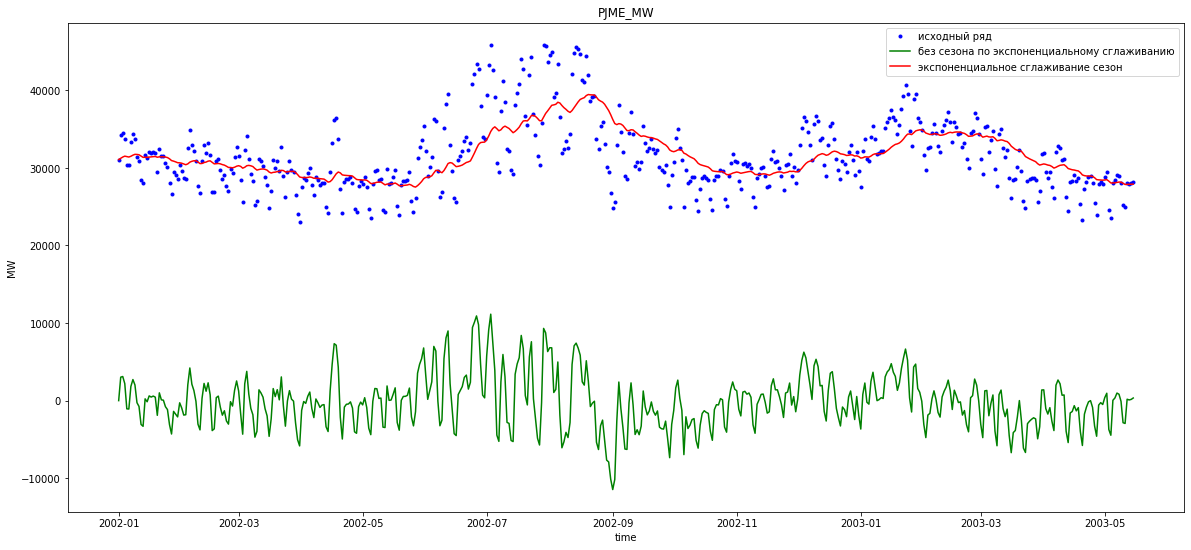

In [27]:
data_exp_1 = exponential_smoothing(d_data['PJME_MW'], 0.05)
plt.figure(figsize=(20, 9))
plt.plot(d_data.index[:500], d_data['PJME_MW'].values[:500], '.b',label='исходный ряд')

plt.plot(d_data.index[:500],d_data['PJME_MW'].values[:500] - data_exp_1[:500] , color = 'green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(d_data.index[:500],data_exp_1[:500] , color = 'red', label="экспоненциальное сглаживание сезон");

plt.xlabel('time')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

Уберем сезонную составляющую

In [28]:
data_seson_free = pd.DataFrame(data = (np.array(d_data['PJME_MW']).reshape((d_data['PJME_MW'].shape[0],1)) -data_exp_1))
sm.tsa.stattools.adfuller( data_seson_free.iloc[:,0] , regression = 'ctt')

(-8.365362138561913,
 4.2829746153965626e-11,
 34,
 6024,
 {'1%': -4.373054660566805,
  '5%': -3.833370706612336,
  '10%': -3.55386764946938},
 107622.59914749119)

Обработка данных

In [37]:
df= pd.DataFrame(data=data_exp_1, index = d_data.index)
df.head()
# добавили историю на глубину 
df['t1']=0.0
df.iloc[1:,1]=df.iloc[:-1,0].values
df['t10']=0.0
df.iloc[10:,2]=df.iloc[:-10,0].values
df.fillna(0)
# добавили сглаживание (3 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df[0], 0.01)
df['exp_0_03'] = exponential_smoothing(df[0], 0.03)
df['exp_0_08'] = exponential_smoothing(df[0], 0.08)
# добавим разности - 1-й порядок
df['diff1'] = 0.0
df['diff1'].iloc[1:] = df.iloc[:-1,0].values-df.iloc[1:,0].values

df.head(12)

,0,t1,t10,exp_0_01,exp_0_03,exp_0_08,diff1
Date,,,,,,,
2002-01-01,31080.739130,0.000000,0.000000,31080.739130,31080.739130,31080.739130,0.000000
2002-01-02,31239.779257,31080.739130,0.000000,31082.329532,31085.510334,31093.462341,-159.040127
2002-01-03,31403.384044,31239.779257,0.000000,31085.540077,31095.046546,31118.256077,-163.604787
2002-01-04,31518.987759,31403.384044,0.000000,31089.874554,31107.764782,31150.314611,-115.603714
2002-01-05,31463.294621,31518.987759,0.000000,31093.608754,31118.430677,31175.353012,55.693138
2002-01-06,31406.309057,31463.294621,0.000000,31096.735757,31127.067028,31193.829496,56.985564
2002-01-07,31502.685270,31406.309057,0.000000,31100.795252,31138.335576,31218.537958,-96.376214
2002-01-08,31645.696840,31502.685270,0.000000,31106.244268,31153.556414,31252.710668,-143.011570
2002-01-09,31752.220331,31645.696840,0.000000,31112.704029,31171.516331,31292.671441,-106.523491


Сделаем разбивку данных на тестовую и тренировочную

In [47]:
def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

train, test = split_data_b(df, '10-10-2015')

In [50]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Построим модель с горизонтом предсказания 1 шаг

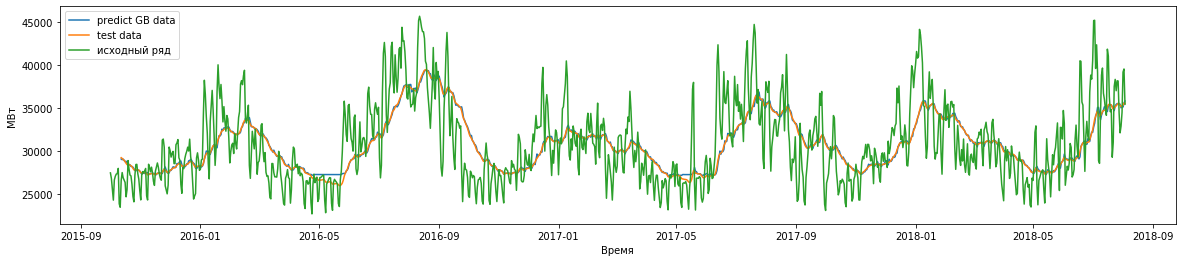

In [51]:
h=1

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(d_data.loc['2015-10-01':].index, d_data.loc['2015-10-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_h1 = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

Построим модель с горизонтом предсказания 10 шагов

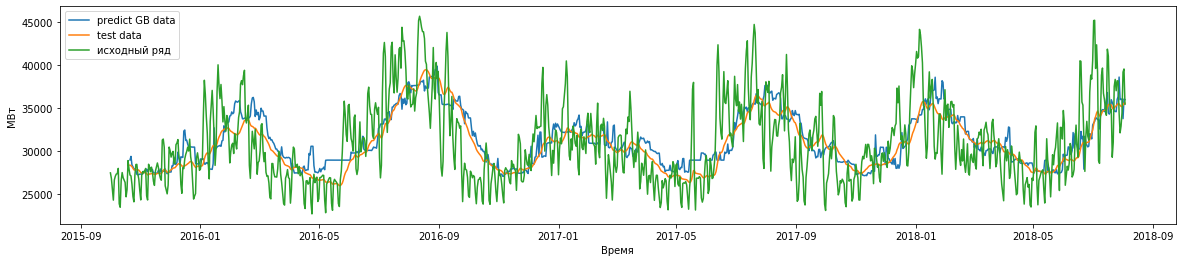

In [52]:
h=10

model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

X_train = train.iloc[:-h,:]
y_train = train[df.columns[0]].values[h:]
X_test = test.iloc[:-h,:]
y_test = test[df.columns[0]].values[h:]

model_gb.fit( X_train, y_train ) 
X_test_pred_gb = model_gb.predict(X_test)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('МВт')
plt.plot(test.index[h:],X_test_pred_gb, label='predict GB data' )
plt.plot(test.index[h:],y_test, label='test data')
plt.plot(d_data.loc['2015-10-01':].index, d_data.loc['2015-10-01':]['PJME_MW'], label='исходный ряд')

plt.legend()
plt.show()

er_h10 = mean_absolute_percentage_error(y_true=y_test, y_pred=X_test_pred_gb)

**Вопрос 2.** Оцените ошибку модели из п.1 .


In [53]:
er_h1

0.5242153525649651

In [54]:
er_h10 

3.2892068637557386

Результаты анализа показали, что горизонт предсказания в один шаг выдает более точный прогноз с меньшей ошибкой MAPE

**Вопрос 3.** Сделайте вывод о том, как изменилась ошибка модели по значениям h.


Горизонт предсказания в 10 шагов демонстрирует менее точные результаты. Для исправления ситуации можно применить 10-дневный ресемплинг.

**Вопрос 4.** Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

а) Изменение температуры за окном :).

**Ответ:** С сезоном

б) Количество денег, которые тратят покупатели в интернет магазине.

**Ответ:** С трендом, если речь идет о последнем десятилетии (рост e-commerce)

в) Вес растущего котенка.

**Ответ:** С трендом в период взросления котенка

г) Прирост объема деревьев в лесу от времени

**Ответ:** С трендом в период роста дерева. Если под "объемом" подразумевается еще и листва, то может наблюдаться сезонность. Для некоторых регионов можно заметить цикличность количества деревьев в лесу в зависимости от человеческого фактора (вырубка -> посадка -> лесовосстановление -> вырубка)